# Notebook 05: Linear Regression - Predicting Sales for New Models

This notebook develops a regression model and evaluates predictions for new model sales using attributes for watches in datasets cleaned in [Notebook 1: Data Cleaning](01_data_cleaning.ipynb).

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression, LinearRegression, RidgeCV, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.impute import KNNImputer

# custom function imports
from custom_functions import *

In [2]:
# Import data
df_all_models = pd.read_csv('../data/cleaned_datasets/df_models.csv')

time_now = datetime.datetime.now()
df_models = df_all_models.dropna(subset=time_now.strftime(f"%Y-%m"))

In [3]:
df_models = df_models.merge(pd.DataFrame(return_date_col(df_models.set_index('style_id')).T.sum(),columns=['overall_sales']),left_on = 'style_id',right_index=True)

### Train-test split

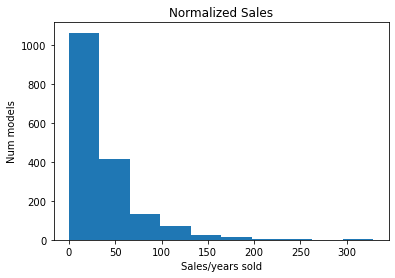

In [4]:
# Calculate a target value - Normalized Sales, which is the overall sales divided by the number of years that the model was sold
yearly_sales = return_sales(df_models,'style_id').resample('Y').sum().T
norm_sales = []
for i,x in enumerate(yearly_sales.index):
    years_of_sales = sum([1 for sales in yearly_sales.loc[x,yearly_sales.iloc[:,0:-1].columns] if sales > 0])
    if yearly_sales.iloc[i,-1] > 0:
        years_of_sales += 4/12
    if years_of_sales == 0:
        norm_sales.append(0)
    else:
        norm_sales.append(df_models.loc[i,'overall_sales']/years_of_sales)
yearly_sales['norm_sales'] = norm_sales
df_models = df_models.merge(yearly_sales[['norm_sales']],left_on = 'style_id',right_index=True)

plt.title('Normalized Sales')
plt.hist(norm_sales)
plt.xlabel('Sales/years sold')
plt.ylabel('Num models');

In [5]:
attributes = ['retail_price', 'collection', 'color', 'band_color',
       'gender', 'case_size', 'band_material']

X = df_models[attributes]

y = df_models['norm_sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [6]:
X_train.columns

Index(['retail_price', 'collection', 'color', 'band_color', 'gender',
       'case_size', 'band_material'],
      dtype='object')

In [7]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1293 entries, 453 to 1126
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   retail_price   1293 non-null   float64
 1   collection     1292 non-null   object 
 2   color          1293 non-null   object 
 3   band_color     1293 non-null   object 
 4   gender         1293 non-null   object 
 5   case_size      1293 non-null   object 
 6   band_material  1293 non-null   object 
dtypes: float64(1), object(6)
memory usage: 80.8+ KB


## Baseline Model

In [8]:
baseline = np.full_like(y_test, y_train.mean())

In [9]:
rmse_baseline = mean_squared_error(y_test,baseline,squared=False)
rmse_baseline

30.549539363532595

In [10]:
residuals_baseline = y_test - baseline

In [11]:
r2_baseline = r2_score(y_test,baseline)
r2_baseline

-0.005632179565686846

/Applications/anaconda3/lib/python3.8/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in true_divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


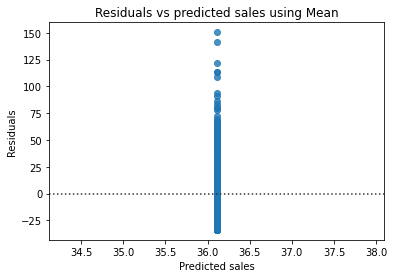

In [12]:
sns.residplot(x = baseline,
              y = residuals_baseline,
              lowess = True,
              line_kws = {'color':'red'})
plt.title('Residuals vs predicted sales using Mean')
plt.xlabel('Predicted sales')
plt.ylabel('Residuals');

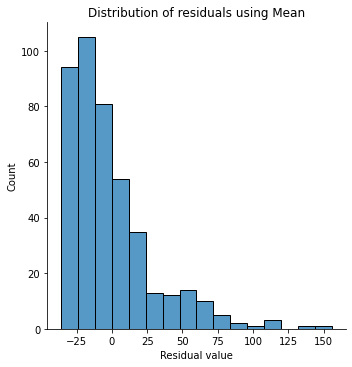

In [13]:
# Create residuals histogram to check for normal distribution of errors
sns.displot(residuals_baseline, binwidth =12)
plt.title('Distribution of residuals using Mean')
plt.xlabel('Residual value');

Definitely not normally distributed. There is a tail for the higher sales models.

## Exploring different models

In [14]:
pipe_lr = Pipeline([
    ('ct',ct),
    ('ss',StandardScaler()),
    ('lr',LinearRegression())
])

NameError: name 'ct' is not defined

In [ ]:
pipe_lr.fit(X_train,y_train)
pipe_lr.score(X_train,y_train), pipe_lr.score(X_test,y_test)

In [ ]:
preds_lr = pipe_lr.predict(X_test)

In [ ]:
preds_lr_zero = [x if x > 0 else 0 for x in preds_lr]
preds_lr_zero = [x if x < 1000 else 0 for x in preds_lr_zero]

In [ ]:
residuals_lr = y_test - preds_lr_zero

In [ ]:
mean_squared_error(y_test, preds_lr_zero)

In [ ]:
plt.scatter(preds_lr_zero,y_test)
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)
plt.xlabel('Predicted sales')
plt.ylabel('Actual sales')
plt.title('Predicted vs Actual Sales: Linear Regression');

In [ ]:
sns.residplot(x = y_test,
              y = residuals_lr,
              lowess = True,
              line_kws = {'color':'red'})
plt.title('Residuals vs predicted sales: Linear Regression')
plt.xlabel('Predicted sales')
plt.ylabel('Residuals');

In [ ]:
# Create residuals histogram to check for normal distribution of errors
sns.displot(residuals_lr, binwidth =12)
plt.title('Distribution of residuals: Linear Regression')
plt.xlabel('Residual value');

Errors appear to be normally distributed.

In [ ]:
def create_evaluate_model(model, X, y):
    print(model[1])
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    
    ct = ColumnTransformer([('ohe',OneHotEncoder(drop='first',sparse=False,handle_unknown='ignore'),
                         attributes[1::])],
                      remainder='passthrough',
                      verbose_feature_names_out=False)
    
    pipe = Pipeline([
        ('ct',ct),
        ('ss',StandardScaler()),
        model
    ])

    pipe.fit(X_train,y_train)
    print('Train score:', pipe.score(X_train,y_train))
    print('Test raw score:', pipe_lr.score(X_test,y_test))

    preds = pipe.predict(X_test)

    preds = [x if x > 0 else 0 for x in preds]
    preds = [x if x < 1000 else 0 for x in preds]

    test_cleaned_rmse = mean_squared_error(y_test, preds,squared=False)

    print('Test cleaned score:', r2_score(y_test, preds))
    print('Test cleaned RMSE:',test_cleaned_rmse)
    print('Baseline RMSE:', mean_squared_error(y_test,np.full_like(y_test, y_train.mean()),squared=False))
    
    residuals = y_test - preds
    plt1 = plt.figure()
    plt.scatter(preds,y_test)
    xpoints = ypoints = plt.xlim()
    plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)
    plt.xlabel('Predicted sales')
    plt.ylabel('Actual sales')
    plt.title(f'Predicted vs Actual Sales: {model[1]}');

    plt2 = plt.figure()
    plt2.suptitle(f'Residuals vs predicted sales: {model[1]}')
    sns.residplot(x = y_test,
                  y = residuals,
                  lowess = True,
                  line_kws = {'color':'red'})
    plt.xlabel('Predicted sales')
    plt.ylabel('Residuals');
    
    print()
    return preds, test_cleaned_rmse

In [ ]:
def plot_preds(y_test, preds, model_name):
    """ This function creates two plots: the predictions against the actual values, and the predictions against the residuals.
    
    Args:
        y_test (Pandas series): actual values
        preds (Pandas series): predictions
    """    
    residuals = y_test - preds
    plt1 = plt.figure()
    plt.scatter(preds,y_test)
    xpoints = ypoints = plt.xlim()
    plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)
    plt.xlabel('Predicted sales')
    plt.ylabel('Actual sales')
    plt.title(f'Predicted vs Actual Sales: {model_name}');

    plt2 = plt.figure()
    plt2.suptitle(f'Residuals vs predicted sales: {model_name}')
    sns.residplot(x = y_test,
                  y = residuals,
                  lowess = True,
                  line_kws = {'color':'red'})
    plt.xlabel('Predicted sales')
    plt.ylabel('Residuals');
    

In [ ]:
def create_evaluate_model(model, X, y):
    print(model[1])
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    
    pipe = Pipeline([
        ('ct',ct),
        ('ss',StandardScaler()),
        model
    ])

    pipe.fit(X_train,y_train)
    print('Train score:', pipe.score(X_train,y_train))
    print('Test raw score:', pipe_lr.score(X_test,y_test))

    preds = pipe.predict(X_test)

    preds = [x if x > 0 else 0 for x in preds]
    preds = [x if x < 1000 else 0 for x in preds]

    test_cleaned_rmse = mean_squared_error(y_test, preds,squared=False)

    print('Test cleaned score:', r2_score(y_test, preds))
    print('Test cleaned RMSE:',test_cleaned_rmse)
    print('Baseline RMSE:', mean_squared_error(y_test,np.full_like(y_test, y_train.mean()),squared=False))
    
    plot_preds(y_test, preds, model[0])
    
    print()
    return preds, test_cleaned_rmse

In [ ]:
models = [('lr',LinearRegression()), ('ridge',RidgeCV(alphas=np.logspace(0,5,100))),
          ('lasso',LassoCV(alphas=np.arange(0.001,10,1))),('knn',KNeighborsRegressor(n_neighbors=3)),
          ('rf', RandomForestRegressor(n_estimators=500)), ('ab', AdaBoostRegressor(base_estimator=RandomForestRegressor())),
          ('et', ExtraTreesRegressor(n_estimators=200))]

In [ ]:
best_rmse = 1000000
dcolumnsreds = X_test.copy()
df_preds['y_test'] = y_test
df_preds = df_preds[['y_test']]
for model in models:
    preds, rmse = create_evaluate_model(model, X, y)
    df_preds[f'preds_{model[0]}'] = preds
    if rmse < best_rmse:
        best_rmse = rmse
        best_model = model[0]
        
print('Best RMSE:', best_rmse)
print('Best model:', best_model)

In [ ]:
df_preds_avg = df_preds[['preds_ridge','preds_rf']]
df_preds['avg'] = 0
for pred in df_preds_avg:
    df_preds['avg'] = df_preds['avg'] + df_preds_avg[pred]
df_preds['avg'] = df_preds['avg']/len(df_preds_avg.columns)

In [ ]:
df_preds

In [ ]:
mean_squared_error(y_test,df_preds['avg'],squared=False)

In [ ]:
plot_preds(y_test,df_preds['avg'],'Average of Models')

## Production model

In [ ]:
# Create new data frame with attributes from model to make predictions for new models in proposal
test = df_new_models[attributes]

# Impute missing retail prices
knn_imp = KNNImputer()
test['retail_price'] = knn_imp.fit_transform(test[['retail_price']])

# Fix small casting issue
test['case_size'] = test['case_size'].astype(str)

# Setup pipeline for preprocessing and modeling
ct = ColumnTransformer([('ohe',OneHotEncoder(drop='first',sparse=False,handle_unknown='ignore'),
                         attributes[1::])],
                      remainder='passthrough',
                      verbose_feature_names_out=False)
pipe = Pipeline([
    ('ct',ct),
    ('ss',StandardScaler()),
    ('rf',RandomForestRegressor(n_estimators=500))
])

# Fit model with train set
pipe.fit(X_train,y_train)

# Generate predictions for new models
preds = pipe.predict(test)

# Save new model predictions (monthly order) to csv
new_model_predictions = df_new_models[['style_id']]
new_model_predictions['monthly_predictions_Q3'] = preds/12
new_model_predictions.to_csv('../cleaned_datasets/new_models_predictions.csv',index=False)